In [1]:
from __builtin__ import False

## 5.3.1 Feature extraction

In [2]:
from keras.applications import VGG16

Using TensorFlow backend.


In [3]:
conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

In [4]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

### 5.3.1.A Feature extraction Way A

Running the convolutional base over our dataset, recording its output to a Numpy array
on disk, then using this data as input to a standalone densely-connected classifier similar to those you have seen in the first chapters of this book. This solution is very fast and cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline.
However, for the exact same reason, this technique would not allow us to leverage data
augmentation at all.

In [5]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'kaggle-dogs-cats-dataset-reduced'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)

batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=sample_count)
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary'
    )
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` onces every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [6]:
print train_features.shape
print train_labels.shape

(2000, 4, 4, 512)
(2000,)


We will feed them to a densely-connected classifier, so first we must flatten them to (samples,
8192).

(4 x 4 x 512 = 8192)

In [7]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [8]:
print train_features.shape

(2000, 8192)


At this point, we can define our densely-connected classifier (note the use of dropout
for regularization), and train it on the data and labels that we just recorded:

In [9]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
    optimizer=optimizers.RMSprop(lr=1e-4),
    loss='binary_crossentropy',
    metrics=['acc']
)

history = model.fit(
    train_features, train_labels,
    epochs=30,
    batch_size=20,
    validation_data=(validation_features, validation_labels),
    verbose=2
)

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
0s - loss: 0.4437 - acc: 0.7870 - val_loss: 0.2973 - val_acc: 0.8860
Epoch 2/30
0s - loss: 0.2922 - acc: 0.8690 - val_loss: 0.2728 - val_acc: 0.8790
Epoch 3/30
0s - loss: 0.2400 - acc: 0.9035 - val_loss: 0.2621 - val_acc: 0.8950
Epoch 4/30
0s - loss: 0.2038 - acc: 0.9195 - val_loss: 0.2725 - val_acc: 0.8850
Epoch 5/30
0s - loss: 0.1706 - acc: 0.9355 - val_loss: 0.2414 - val_acc: 0.9020
Epoch 6/30
0s - loss: 0.1527 - acc: 0.9455 - val_loss: 0.2359 - val_acc: 0.9050
Epoch 7/30
0s - loss: 0.1262 - acc: 0.9530 - val_loss: 0.2645 - val_acc: 0.9010
Epoch 8/30
0s - loss: 0.1128 - acc: 0.9595 - val_loss: 0.2413 - val_acc: 0.8940
Epoch 9/30
0s - loss: 0.0990 - acc: 0.9650 - val_loss: 0.2613 - val_acc: 0.9000
Epoch 10/30
0s - loss: 0.0943 - acc: 0.9680 - val_loss: 0.2523 - val_acc: 0.8990
Epoch 11/30
0s - loss: 0.0767 - acc: 0.9740 - val_loss: 0.2681 - val_acc: 0.8980
Epoch 12/30
0s - loss: 0.0667 - acc: 0.9765 - val_loss: 0.2649 - val_a

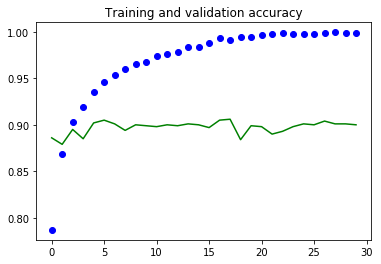

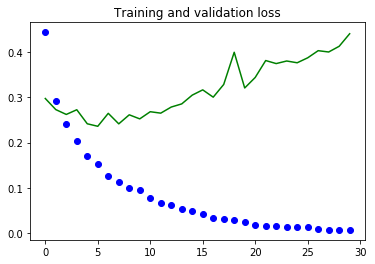

In [10]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo')
plt.plot(epochs, val_acc, 'g')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'g')
plt.title('Training and validation loss')

plt.show()

### 5.3.1.B Feature extraction Way B

In [11]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [12]:
print('This is the number of trainable weights before freezing the conv base: ', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights after freezing the conv base: ', len(model.trainable_weights))

('This is the number of trainable weights before freezing the conv base: ', 30)
('This is the number of trainable weights after freezing the conv base: ', 4)


In [13]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, # This is the target directory
    target_size=(150, 150), # All images will be resized to 150x150
    batch_size=20,
    class_mode='binary' # Since we use binary_crossentropy loss, we need binary labels
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-4),
    metrics=['acc']
)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=40,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=2
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/40
15s - loss: 0.7170 - acc: 0.5190 - val_loss: 0.6683 - val_acc: 0.6610
Epoch 2/40
15s - loss: 0.6408 - acc: 0.6460 - val_loss: 0.4955 - val_acc: 0.7500
Epoch 3/40
14s - loss: 0.5452 - acc: 0.7185 - val_loss: 0.3852 - val_acc: 0.8600
Epoch 4/40
14s - loss: 0.4408 - acc: 0.7965 - val_loss: 0.2404 - val_acc: 0.9050
Epoch 5/40
14s - loss: 0.3997 - acc: 0.8280 - val_loss: 0.1794 - val_acc: 0.9300
Epoch 6/40
14s - loss: 0.3708 - acc: 0.8440 - val_loss: 0.1876 - val_acc: 0.9250
Epoch 7/40
14s - loss: 0.3228 - acc: 0.8690 - val_loss: 0.2142 - val_acc: 0.9020
Epoch 8/40
15s - loss: 0.3091 - acc: 0.8760 - val_loss: 0.2307 - val_acc: 0.9110
Epoch 9/40
14s - loss: 0.2673 - acc: 0.8835 - val_loss: 0.5098 - val_acc: 0.8520
Epoch 10/40
15s - loss: 0.3211 - acc: 0.8800 - val_loss: 0.1346 - val_acc: 0.9520
Epoch 11/40
14s - loss: 0.2317 - acc: 0.9050 - val_loss: 0.2276 - val_acc: 0.9140
Epoch 12/40
14s - loss:

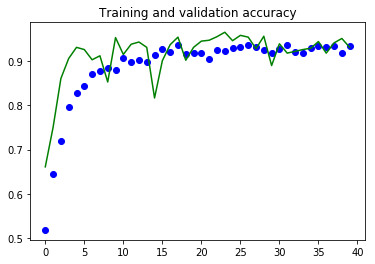

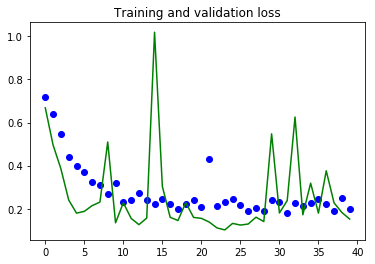

In [14]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo')
plt.plot(epochs, val_acc, 'g')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'g')
plt.title('Training and validation loss')

plt.show()

## 5.3.2 Fine-tuning

In [15]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [16]:
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-4),
    metrics=['acc']
)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=2
)

Epoch 1/100
9s - loss: 0.1398 - acc: 0.9460 - val_loss: 0.1640 - val_acc: 0.9450
Epoch 2/100
9s - loss: 0.1250 - acc: 0.9535 - val_loss: 0.1979 - val_acc: 0.9440
Epoch 3/100
9s - loss: 0.1339 - acc: 0.9605 - val_loss: 0.1976 - val_acc: 0.9340
Epoch 4/100
9s - loss: 0.1498 - acc: 0.9530 - val_loss: 0.2239 - val_acc: 0.9380
Epoch 5/100
9s - loss: 0.1181 - acc: 0.9665 - val_loss: 0.1589 - val_acc: 0.9460
Epoch 6/100
8s - loss: 0.1494 - acc: 0.9580 - val_loss: 0.2651 - val_acc: 0.9380
Epoch 7/100
9s - loss: 0.1293 - acc: 0.9575 - val_loss: 0.2924 - val_acc: 0.9540
Epoch 8/100
9s - loss: 0.1262 - acc: 0.9560 - val_loss: 0.2089 - val_acc: 0.9470
Epoch 9/100
9s - loss: 0.1394 - acc: 0.9605 - val_loss: 0.2349 - val_acc: 0.9470
Epoch 10/100
9s - loss: 0.1468 - acc: 0.9525 - val_loss: 0.1514 - val_acc: 0.9410
Epoch 11/100
9s - loss: 0.1325 - acc: 0.9565 - val_loss: 0.2960 - val_acc: 0.9180
Epoch 12/100
9s - loss: 0.1253 - acc: 0.9530 - val_loss: 0.2272 - val_acc: 0.9420
Epoch 13/100
9s - loss: 0

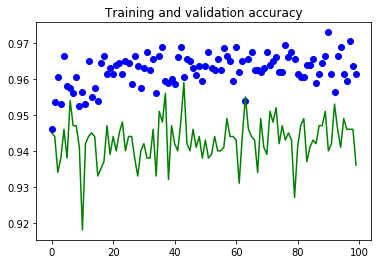

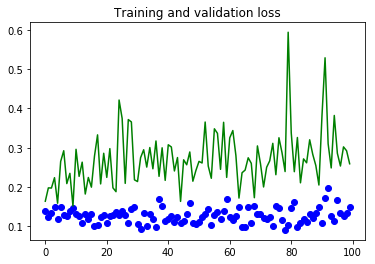

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo')
plt.plot(epochs, val_acc, 'g')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'g')
plt.title('Training and validation loss')

plt.show()

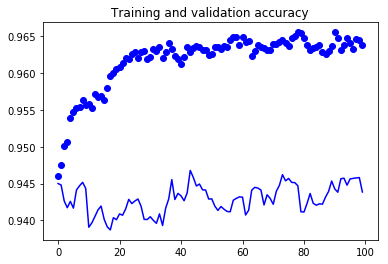

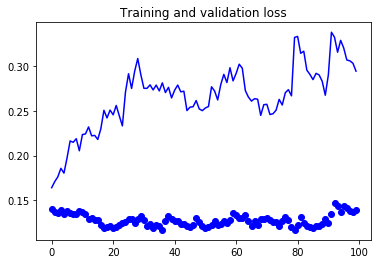

In [20]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
    
plt.plot(epochs, smooth_curve(acc), 'bo')
plt.plot(epochs, smooth_curve(val_acc), 'b')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo')
plt.plot(epochs, smooth_curve(val_loss), 'b')
plt.title('Training and validation loss')

plt.show()